### TP 2 - Visión por Computadora

Se importan las librerías necesarias para la resolución del trabajo práctico.

In [32]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [33]:
def image_quality_measure_FM(frame, debug=False):
    """
    Mide la calidad de la imagen en el dominio de la frecuencia para una matriz de enfoque compuesta
    por un arreglo de NxM elementos rectangulares equiespaciados.
    
    Parámetros:
    frame (numpy.ndarray): La imagen de entrada en escala de grises.

    Retorno:
    float: La medida de calidad promedio de la imagen (FM).
    """

    # Paso 1: Calcular F, que es la representación de la Transformada de Fourier de la imagen I
    F = np.fft.fft2(frame)
    
    if debug:
        print('F.shape = ', F.shape)
    
    # Paso 2: Obtener Fc, que se obtiene desplazando F al centro
    Fc = np.fft.fftshift(F)

    if debug:
        print('Fc.shape = ', Fc.shape)
    
    # Paso 3: Calcular AF = abs(Fc), siendo AF el valor absoluto de la Transformada de Fourier centrada de la imagen I
    AF = np.abs(Fc)

    if debug:
        print('AF.shape = ', AF.shape)
    
    # Paso 4: Calcular M = max(AF), siendo M el valor máximo del componente de frecuencia en F
    M = np.max(AF)
    
    # Paso 5: Calcular TH = el número total de píxeles en F cuyo valor de píxel > thres, donde thres = M/1000
    thres = M / 1000
    TH = np.sum(AF > thres)
    
    # Paso 6: Calcular la medida de calidad de la imagen (FM) a partir de la ecuación presentada en el paper: FM = TH / (M * N)
    FM = TH / (frame.shape[0] * frame.shape[1])

    if debug:
        print('F.shape = ', F.shape)
        print(f"Valor máximo (M): {M}")
        print(f"Umbral (thres): {thres}")
        print(f"Número total de píxeles (TH): {TH}")
        print(f"Tamaño de la imagen (M*N): {frame.shape[0] * frame.shape[1]}")
    
    return FM



In [34]:
def  absolute_central_moment_MIS1(frame, debug=False):
    """
    Absolute central moment (MIS1). Algoritmo del apéndice A.1 del paper 
    "Analysis of focus measure operators in shape-from-focus" (Said Pertuz, Domenec Puig, Miguel Angel García)

    Parámetros:
    frame (numpy.ndarray): La imagen de entrada en escala de grises.
    debug (bool): Si es True, imprime información de depuración.

    Devolver:
    float: Valor de la métrica MIS1.
    """
    
    # Se obtiene el histograma de la imagen
    hist, _ = np.histogram(frame, bins= 256 , range=(0, 256))
    
    # Se calcula la probabilidad para cada nivel de gris
    Pk = hist / np.sum(hist)
    
    # Se calcula la media para la intensidad de los píxeles de la imagen
    m = np.mean(frame)
    
    # Se calcula la métrica
    ACMo = np.sum(np.abs(np.arange(256) - m) * Pk)

    return ACMo

In [35]:
def measure_over_matrix(frame_rgb, n, m, roi_area, metric, spacing=10, debug=False):
    """
    Mide la calidad de la imagen en el dominio de la frecuencia para una matriz de enfoque compuesta
    por un arreglo de NxM elementos rectangulares equiespaciados.
    
    Parámetros:
    frame_rgb (numpy.ndarray): La imagen de entrada en formato RGB.
    n (int): Número de elementos en la dirección vertical.
    m (int): Número de elementos en la dirección horizontal.
    spacing (int): Espaciado entre los elementos.

    Retorno:
    float: La medida de calidad promedio de la imagen (FM).
    """
    metric_values = [] # Medidas sobre cada elemento de la matriz
    frame = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2GRAY)

    # Se calcula el área total de la imagen
    frame_area = frame.shape[0] * frame.shape[1]
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    # Se calcula el área total de los elementos (según roi_area, ej. si roi_area es 0.1, es el 10% de la imagen)
    total_element_area = roi_area * frame_area

    # Se calcula el tamaño del lado de cada cuadrado
    element_side = int(np.sqrt(total_element_area / (n * m)))

    # Se calcula el tamaño total que ocupará la matriz
    total_matrix_width = m * element_side + (m - 1) * spacing
    total_matrix_height = n * element_side + (n - 1) * spacing

    # Se calculan los márgenes para centrar la cuadrícula en el frame
    start_x = (frame_width - total_matrix_width) // 2
    start_y = (frame_height - total_matrix_height) // 2

    # Se procesa cada uno de los cuadrados de la matriz
    for i in range(n):
        for j in range(m):
            x_start = start_x + j * (element_side + spacing)
            y_start = start_y + i * (element_side + spacing)
            x_end = x_start + element_side
            y_end = y_start + element_side

            # Se valida que el cuadrado no quede fuera del frame
            if x_end < frame_width and y_end < frame_height:
                # Se obtiene la porción de imagen correspondiente
                roi = frame[y_start:y_end, x_start:x_end]
                
                # Se calcula la métrica para el cuadrado
                quality_measure = metric(roi, debug)
                metric_values.append(quality_measure)

    # Se calcula la mediana de las medidas para cada cuadrado
    average_fm = np.median(metric_values)

    return average_fm

In [36]:
def draw_matrix(frame_rgb, n, m, roi_area, display_color, spacing=10):
    """
    Dado un frame, dibuja una matriz de enfoque y devuelve el resultado.
    
    Parámetros:
    frame_rgb (numpy.ndarray): La imagen de entrada en formato RGB.
    n (int): Número de elementos en la dirección vertical.
    m (int): Número de elementos en la dirección horizontal.
    display_color: Color de la matriz
    spacing (int): Espaciado entre los elementos.

    Retorno:
    numpy.ndarray: Imagen con la matriz dibujada.
    """
    frame = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2GRAY)

    # Se calcula el área total de la imagen
    frame_area = frame.shape[0] * frame.shape[1]
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    # Se calcula el área total de los elementos (según roi_area, ej. si roi_area es 0.1, es el 10% de la imagen)
    total_element_area = roi_area * frame_area

    # Se calcula el tamaño del lado de cada cuadrado
    element_side = int(np.sqrt(total_element_area / (n * m)))

    # Se calcula el tamaño total que ocupará la matriz
    total_matrix_width = m * element_side + (m - 1) * spacing
    total_matrix_height = n * element_side + (n - 1) * spacing

    # Se calculan los márgenes para centrar la cuadrícula en el frame
    start_x = (frame_width - total_matrix_width) // 2
    start_y = (frame_height - total_matrix_height) // 2

    # Se dibujan los cuadrados con el color correspondiente
    for i in range(n):
        for j in range(m):
            x_start = start_x + j * (element_side + spacing)
            y_start = start_y + i * (element_side + spacing)
            x_end = x_start + element_side
            y_end = y_start + element_side

            if x_end < frame_width and y_end < frame_height:
                cv2.rectangle(frame_rgb, (x_start, y_start), (x_end, y_end), display_color, 2)

    return frame_rgb

In [37]:
def unsharp_masking(frame, sigma=1.0, definition=5.5, debug=False):
    """
    Aplica unsharp masking a un frame.

    Parámetros:
    frame (numpy.ndarray): La imagen de entrada.
    sigma (float): Desviación estándar para el filtro gaussiano.
    definition (float): Factor que se le aplicará las máscaras (alpha y -beta en addWeighted).

    Retorno:
    numpy.ndarray: La imagen con unsharp masking aplicado.
    """
    
    # Se aplica un filtro gaussiano para suavizar la imagen
    blurred_frame = cv2.GaussianBlur(frame, (0, 0), sigma)
    
    # Se crea imagen final restando la imagen suavizada a la imagen original
    img_unsharp = cv2.addWeighted(frame, 1.0 + definition, blurred_frame, -definition, 0)
    
    return img_unsharp

In [38]:
def process_video(video_path, metric, metric_name='', matrix=None, roi_area=0.1, output_video_path=None, apply_unsharp_masking=False, debug=False, threshold_percentile=80):
    """
    Procesa el video, desplegando las métricas correspondientes.

    Parámetros:
    video_path: Path al video.
    metric: Función de la métrica a utilizar
    metric_name: Nombre de la métrica
    matrix: Tamaño de la matriz de enfoque. Si no se recibe se realiza el cálculo sobre el frame completo
    roi_area: Porcentaje del área del frame que utilizará la matriz de enfoque.
    output_video_path: Ruta donde se guardará el video resultado.
    apply_unsharp_masking: Aplicar unsharp masking?
    debug: Modo debug
    """

    captura_video = cv2.VideoCapture(video_path)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    # Se obtienen las dimensiones de los frames
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Se obtiene frame rate del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    delay = int(1000 / fps)

    frames = []
    frame_nums = []
    metrics = []

    # Inicializa el objeto VideoWriter para guardar el video
    if output_video_path is not None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    paused = False

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Se obtiene el número del frame actual
        frame_num = captura_video.get(cv2.CAP_PROP_POS_FRAMES)

        # Se pasa el frame a escala de grises para poder aplicar las métricas de forma más directa
        frame_resized_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Aplica Unsharp Masking en caso que se requiera
        if apply_unsharp_masking:
            frame_resized_gray = unsharp_masking(frame_resized_gray)

        # Se realiza el cálculo de la métrica
        if matrix is not None:
            quality_measure = measure_over_matrix(frame, matrix[0], matrix[1], roi_area, metric, debug=debug)
        else:
            quality_measure = metric(frame_resized_gray, debug=debug)

        frames.append(frame)
        frame_nums.append(frame_num)
        metrics.append(quality_measure)

    # Se libera el video
    captura_video.release()

    # Se calcula el threshold para el percentil recibido por parámetro (default 85)
    threshold = np.percentile(metrics, threshold_percentile)

    # Se procesan los frames y se marcan según el umbral calculado
    for i, frame in enumerate(frames):
        quality_measure = metrics[i]

        # Por defecto el color de los elementos del frame es rojo, y en caso de superar el umbral de enfoque pasa a verde
        display_color = (255, 0, 0)
        if quality_measure >= threshold:
            display_color = (0, 255, 0)
            
            # Si no hay una matriz de enfoque, entonces se dibuja un cuadro verde alrededor del frame
            if matrix is None:
                cv2.rectangle(frame, (0, 0), (frame_width - 1, frame_height - 1), display_color, 2)

        # Se muestra la mediana de la métrica en el video (informativo)
        cv2.putText(frame, f"Mediana metrica ({metric_name}): {quality_measure:.2f}", (10, frame_height - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, display_color, 1)
        
        # Si se indicó una matriz entonces se muestra en el color correspondiente
        if matrix is not None:
            frame = draw_matrix(frame, matrix[0], matrix[1], roi_area, display_color)

        # Se muestra el frame con los datos estampados
        cv2.imshow('Video con matriz de enfoque', frame)

        # Se escribe el frame en el archivo de salida de video (opcional)
        if output_video_path is not None:
            out.write(frame)

        # Con q se finaliza la visualización y con espacio se pausa
        key = cv2.waitKey(delay if not paused else 0) & 0xFF
        if key == ord('q'):
            break
        elif key == ord(' '):
            paused = not paused

    # Se grafica número de frame vs medida de la métrica
    plt.figure()
    #plt.plot(frame_nums, metrics, marker='o', linestyle='-', color='b')
    colors = ['g' if m >= threshold else 'b' for m in metrics]
    plt.scatter(frame_nums, metrics, c=colors)
    plt.xlabel('#Frame')
    plt.ylabel(f'Métrica {metric_name}')
    plt.title(f'Métrica {metric_name} vs #Frame')
    plt.grid(True)
    plt.show()

    # Se cierra el archivo de salida y se cierra todas las ventanas de esta ejecución
    if output_video_path is not None:
        out.release()
    cv2.destroyAllWindows()


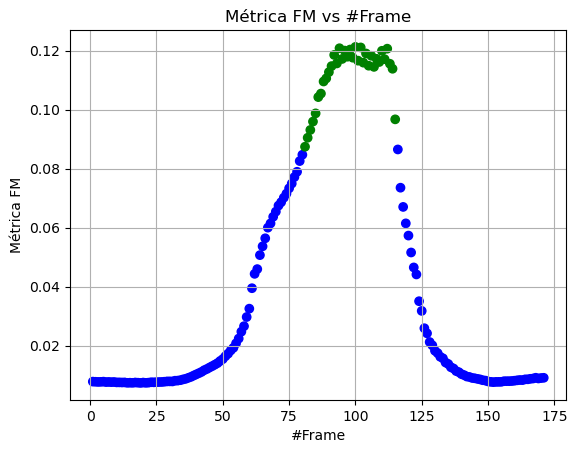

In [39]:
process_video('focus_video.mov', output_video_path='FM_frame_completo.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=True)

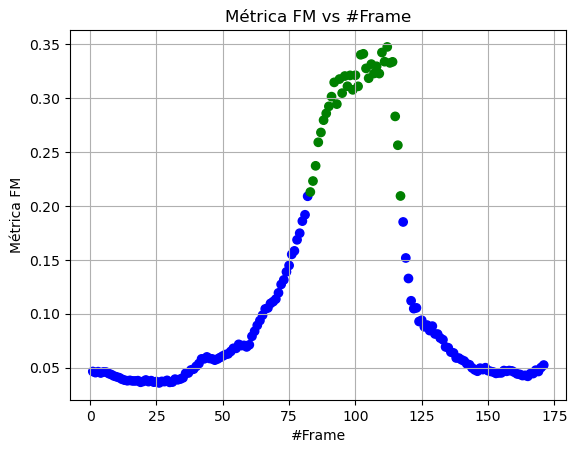

In [40]:
process_video('focus_video.mov', matrix=(1,1), output_video_path='FM_matriz_1x1.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

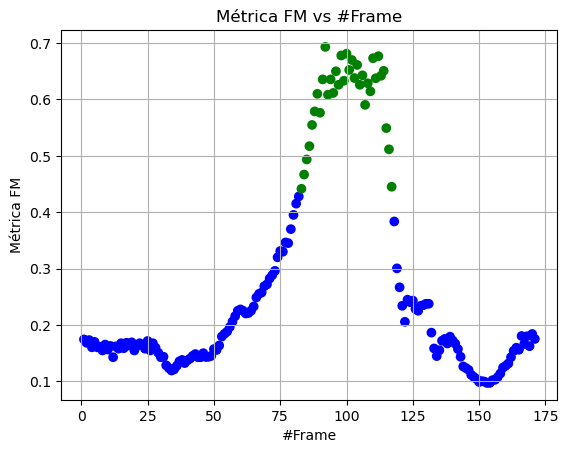

In [41]:
process_video('focus_video.mov', matrix=(3,3), output_video_path='FM_matriz_3x3.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

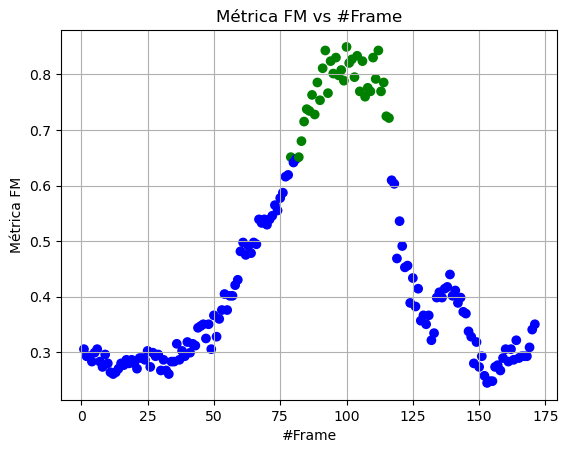

In [42]:
process_video('focus_video.mov', matrix=(7,5), output_video_path='FM_matriz_7x5.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

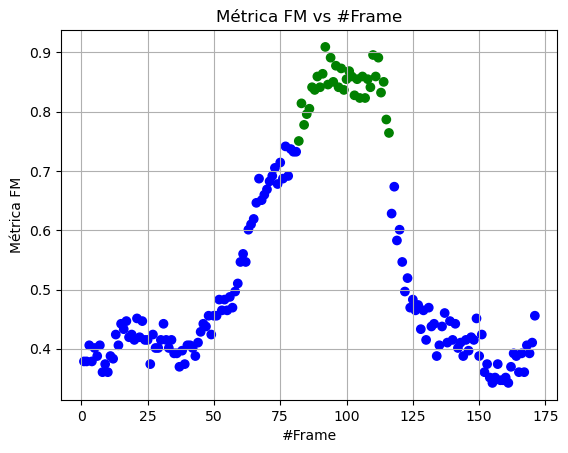

In [43]:
process_video('focus_video.mov', matrix=(7,7), output_video_path='FM_matriz_7x7.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

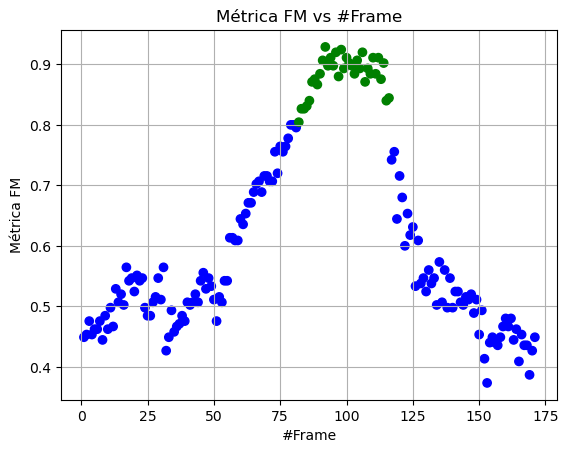

In [44]:
process_video('focus_video.mov', matrix=(10,10), output_video_path='FM_matriz_10x10.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

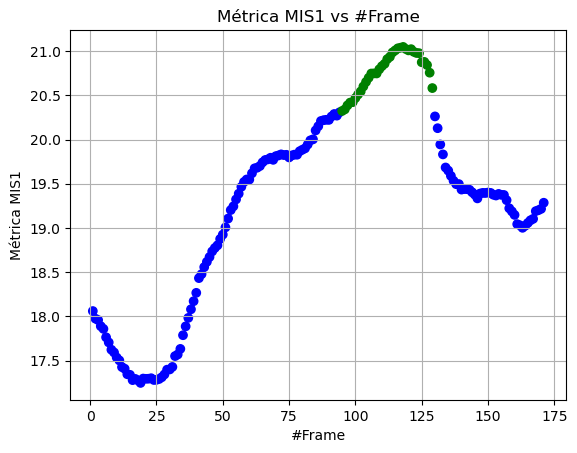

In [45]:
process_video('focus_video.mov', output_video_path='MIS1_frame_completo.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1', apply_unsharp_masking=False)

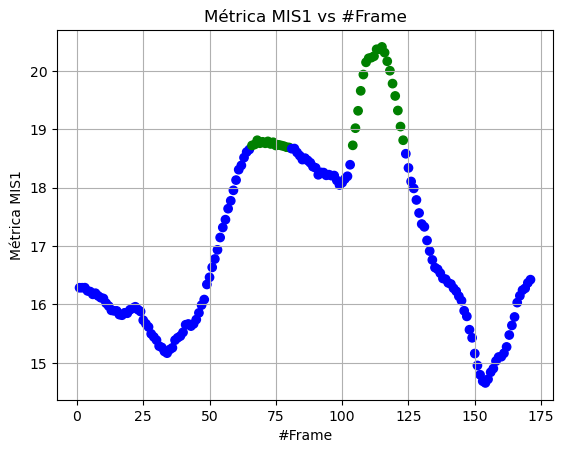

In [46]:
process_video('focus_video.mov', matrix=(1,1), output_video_path='MIS1_matriz_1x1.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1', apply_unsharp_masking=False)

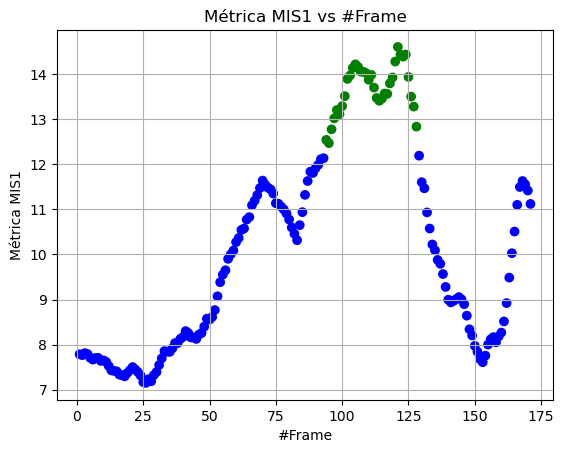

In [47]:
process_video('focus_video.mov', matrix=(3,3), output_video_path='MIS1_matriz_3x3.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1', apply_unsharp_masking=False)

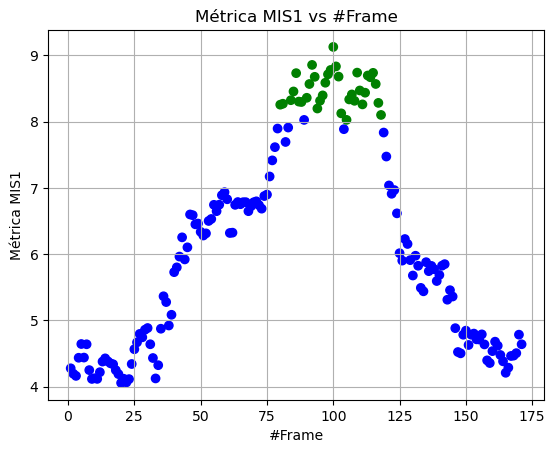

In [48]:
process_video('focus_video.mov', matrix=(7,5), output_video_path='MIS1_matriz_7x5.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1', apply_unsharp_masking=False)

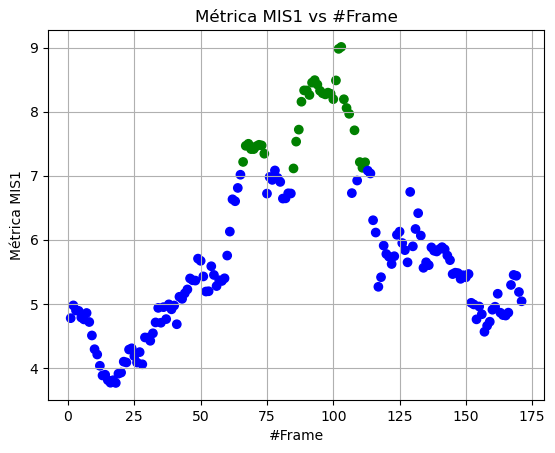

In [49]:
process_video('focus_video.mov', matrix=(7,7), output_video_path='MIS1_matriz_7x7.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1', apply_unsharp_masking=False)